In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse551/Youtube_communities.txt
/kaggle/input/cse551/Collin_CYC_Graph.txt
/kaggle/input/cse551/CYC2008_complexes.txt
/kaggle/input/cse551/roadNet_Texas.txt
/kaggle/input/cse551/Undirected_Youtube_network.txt
/kaggle/input/cse551/Email-Enron.txt


In [18]:
!pip install hypernetx matplotlib scikit-learn
!pip install networkx numpy scikit-learn matplotlib
!pip install python-louvain

In [19]:
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    precision_score,
    recall_score,
    f1_score,
)

In [20]:
# Step 1: Load Graph and Hypergraph
def load_collin_cyc_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(set)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                node1, node2 = line.strip().split()
                G.add_edge(node1, node2)
                hyperedges[node1].add(node2)
                hyperedges[node2].add(node1)

    # Convert to hypergraph
    H = hnx.Hypergraph(hyperedges)
    return G, H


In [21]:
# Step 2: Convert Hypergraph to Weighted Graph
def hypergraph_to_weighted_graph(H):
    G_weighted = nx.Graph()
    for edge, nodes in H.incidence_dict.items():
        nodes = list(nodes)
        for i, u in enumerate(nodes):
            for v in nodes[i + 1:]:
                if G_weighted.has_edge(u, v):
                    G_weighted[u][v]['weight'] += 1
                else:
                    G_weighted.add_edge(u, v, weight=1)
    return G_weighted


In [22]:
# Step 3: Graph Community Detection
def graph_community_detection(G):
    return community_louvain.best_partition(G)


# Step 4: Hypergraph Community Detection
def hypergraph_community_detection(H):
    G_weighted = hypergraph_to_weighted_graph(H)
    if G_weighted.number_of_edges() == 0:
        print("No edges in the weighted graph derived from hypergraph. Cannot detect communities.")
        return {}

    partition = community_louvain.best_partition(G_weighted, weight='weight')
    return partition


# Step 5: Extract Communities
def extract_communities(partition):
    communities = defaultdict(set)
    for node, community in partition.items():
        communities[community].add(node)
    return communities

In [23]:
# Step 6: Save Communities to File
def save_communities_to_file(communities, filename):
    with open(filename, 'w') as file:
        for community_id, nodes in communities.items():
            file.write(f"Community {community_id}: {', '.join(nodes)}\n")
    print(f"Communities saved to {filename}")


# Step 7: Print All Communities
def print_all_communities(communities, label="Community"):
    print(f"\n{label} Communities:")
    for community_id, nodes in communities.items():
        print(f"{label} {community_id}: {', '.join(nodes)}")



In [24]:
# Step 8: Visualize Communities
def visualize_communities(G, communities, label="Graph"):
    pos = nx.spring_layout(G, seed=42)
    colors = [f"C{comm_id % 10}" for comm_id in communities.keys()]  
    plt.figure(figsize=(12, 8))

    for comm_id, nodes in communities.items():
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=list(nodes),
            node_color=colors[comm_id % len(colors)],
            label=f"{label} {comm_id}", node_size=50
        )

    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"{label} Communities")
    plt.legend()
    plt.show()


In [25]:
# Step 9: Evaluate Clustering Metrics
def evaluate_clustering_metrics(graph_partition, hypergraph_partition):
    common_nodes = set(graph_partition.keys()).intersection(hypergraph_partition.keys())
    if not common_nodes:
        print("No common nodes between graph and hypergraph.")
        return

    true_labels = [graph_partition[node] for node in common_nodes]
    pred_labels = [hypergraph_partition[node] for node in common_nodes]

    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    print("\nEvaluation Metrics:")
    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")

In [26]:
# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Step 1: Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    print(f"\nTotal Graph Communities: {len(graph_comm)}")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    hypergraph_comm = extract_communities(hypergraph_partition)
    print(f"\nTotal Hypergraph Communities: {len(hypergraph_comm)}")

    # Step 4: Print Communities
    print_all_communities(graph_comm, "Graph")
    print_all_communities(hypergraph_comm, "Hypergraph")

    # Step 5: Save Communities to File
    save_communities_to_file(graph_comm, "graph_communities.txt")
    save_communities_to_file(hypergraph_comm, "hypergraph_communities.txt")

    # Step 6: Visualize Communities
    #visualize_communities(G, graph_comm, label="Graph")
    #visualize_communities(hypergraph_to_weighted_graph(H), hypergraph_comm, label="Hypergraph")

    # Step 7: Evaluate Clustering Metrics
    evaluate_clustering_metrics(graph_partition, hypergraph_partition)


if __name__ == "__main__":
    main()


Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.

Total Graph Communities: 153

Total Hypergraph Communities: 80

Graph Communities:
Graph 0: YBR123C, YOR110W, YDR362C, YGR047C, YAL001C, YPL007C
Graph 1: YMR231W, YPL045W, YLR396C, YDR080W, YLR148W, YAL002W, YDL077C
Graph 3: YKL081W, YDR280W, YNL232W, YOL021C, YBR118W, YDL111C, YGL213C, YLR398C, YGR095C, YOL142W, YHR069C, YAL003W, YHR081W, YGR158C, YPR189W, YGR195W, YGR285C, YOR001W, YCR035C, YPL048W, YHR064C, YPR080W
Graph 4: YAR002C-A, YAL007C, YGL200C, YML012W
Graph 5: YBR231C, YJL081C, YNL107W, YDL002C, YDR359C, YBR095C, YMR263W, YPR023C, YDR334W, YPL004C, YLR433C, YPL249C, YKL190W, YDR485C, YDR388W, YGR086C, YDR190C, YCR009C, YMR075W, YNL138W, YNL136W, YFL039C, YGR002C, YGL150C, YNL097C, YEL018W, YJL005W, YML041C, YDR207C, YLR052W, YJR082C, YPL139C, YPL181W, YIL084C, YHR090C, YLR385C, YPL235W, YDL076C, YFL013C, YOR141C, YOR244W, YAL013W, YML057W, YAL011W, YBR109C, YNL059C, YLR085C, YOL004W, YMR19

Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.

Total Graph Communities: 153


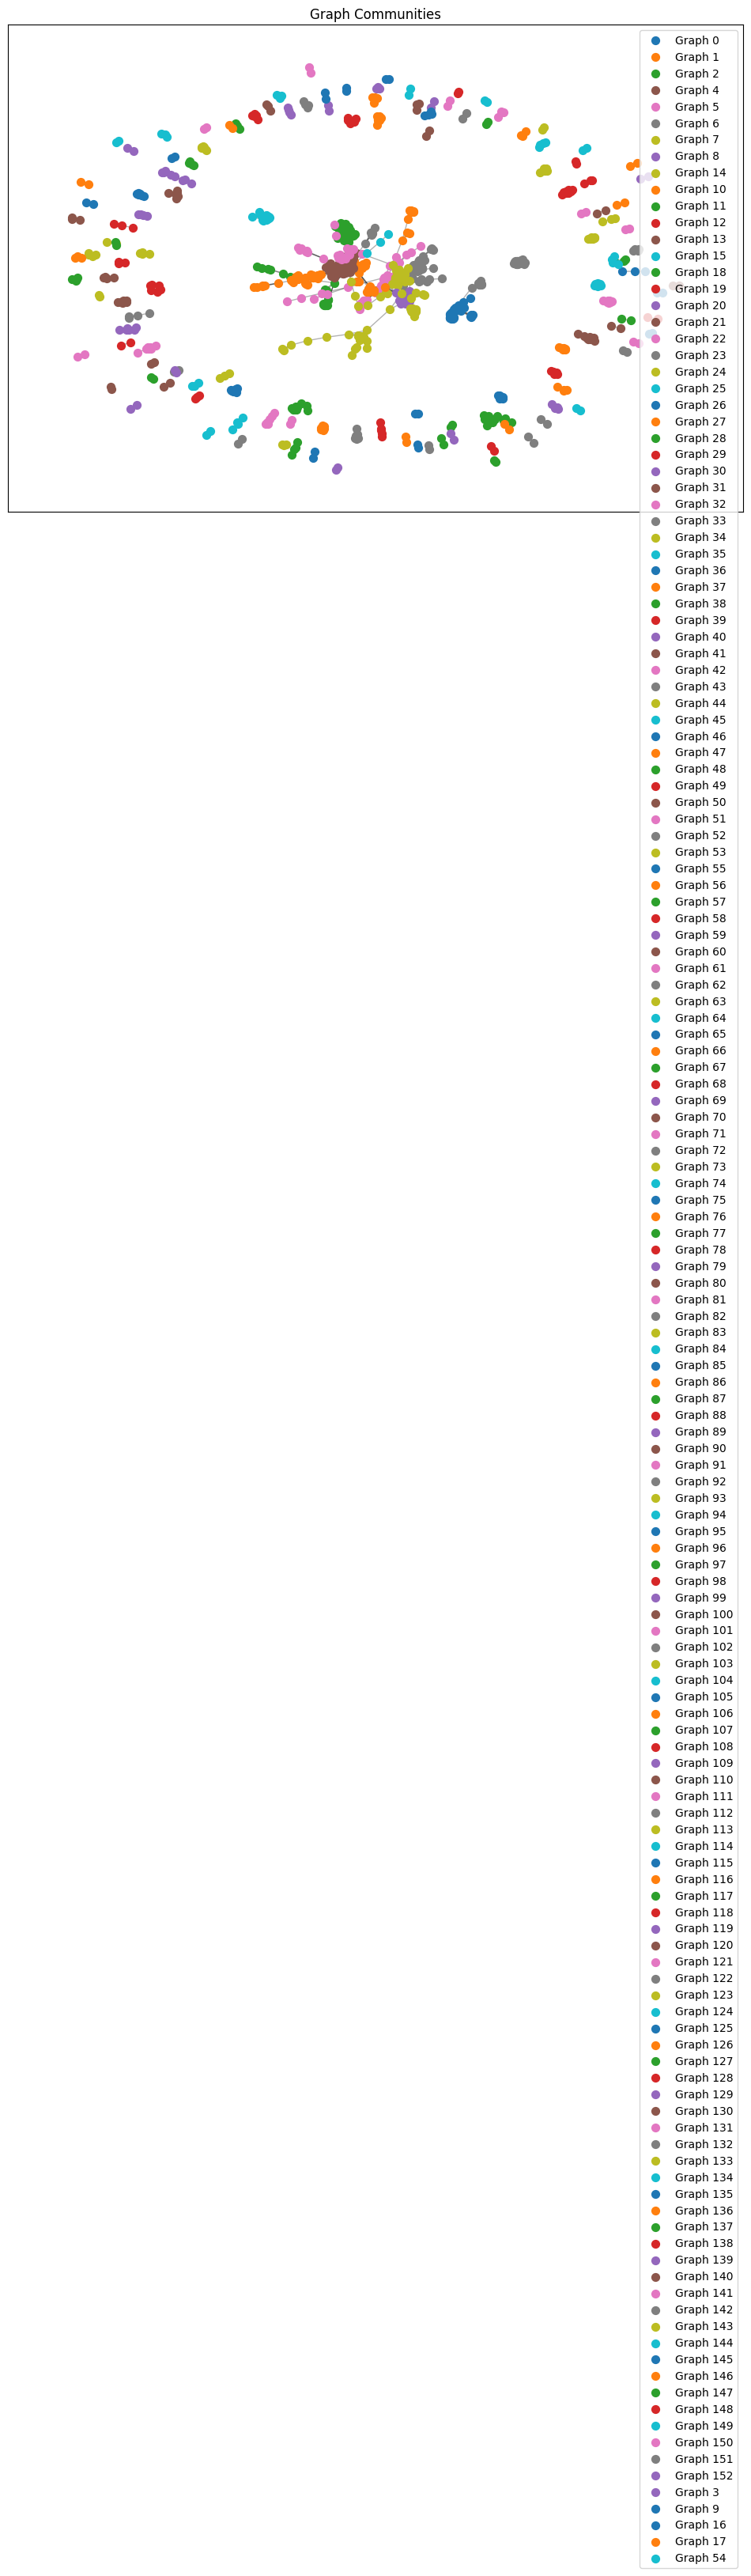

In [27]:
# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Step 1: Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    print(f"\nTotal Graph Communities: {len(graph_comm)}")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    hypergraph_comm = extract_communities(hypergraph_partition)
    #print(f"\nTotal Hypergraph Communities: {len(hypergraph_comm)}")

    # Step 4: Print Communities
    #print_all_communities(graph_comm, "Graph")
    #print_all_communities(hypergraph_comm, "Hypergraph")

    # Step 6: Visualize Communities
    visualize_communities(G, graph_comm, label="Graph")
    #visualize_communities(hypergraph_to_weighted_graph(H), hypergraph_comm, label="Hypergraph")


if __name__ == "__main__":
    main()


Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.


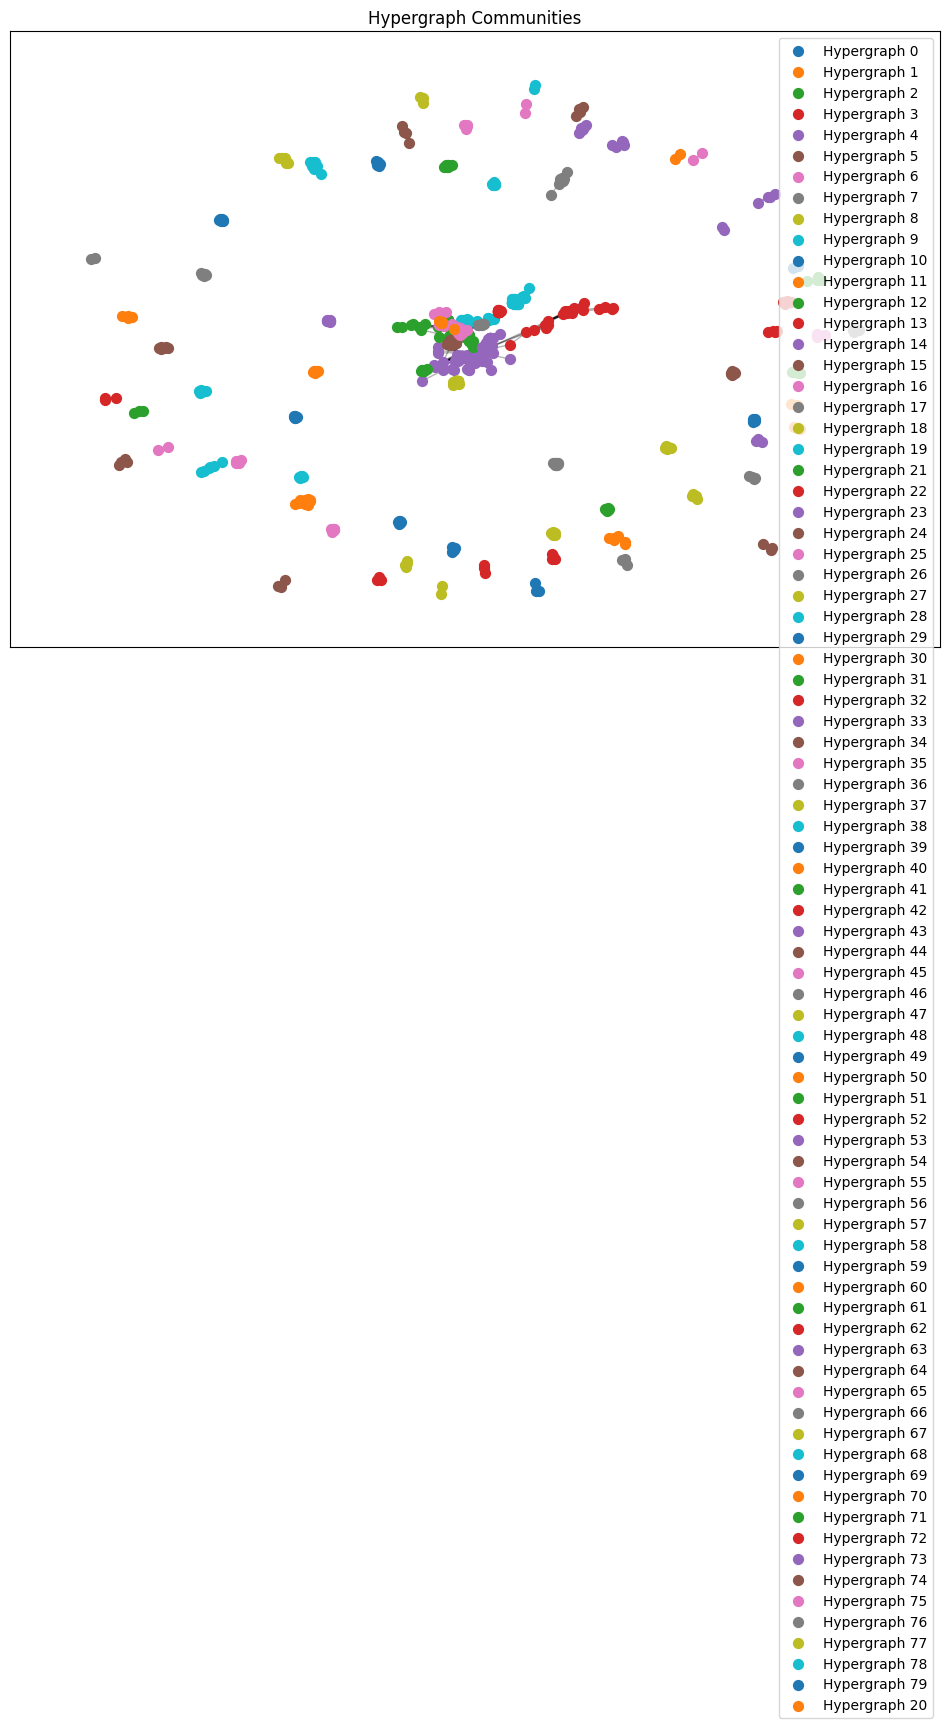

In [28]:
# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Step 1: Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    #print(f"\nTotal Graph Communities: {len(graph_comm)}")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    hypergraph_comm = extract_communities(hypergraph_partition)
    #print(f"\nTotal Hypergraph Communities: {len(hypergraph_comm)}")

    # Step 4: Print Communities
    #print_all_communities(graph_comm, "Graph")
    #print_all_communities(hypergraph_comm, "Hypergraph")

    # Step 6: Visualize Communities
    #visualize_communities(G, graph_comm, label="Graph")
    visualize_communities(hypergraph_to_weighted_graph(H), hypergraph_comm, label="Hypergraph")


if __name__ == "__main__":
    main()
